# 문제 설명

서울시에서 2015년 부터 시행한 무인 공공자전거 대여 서비스 “따릉이”는 해가 지날수록 이용하는 시민이 늘어나는 추세입니다. 하지만 2020년 9월 서울환경연합에서 진행한 ‘[자전거 이용에 관한 설문조사](http://ecoseoul.or.kr/archives/41430)’에 따르면 조사 대상 2700명 중 27%의 응답자는 따릉이 이용 시 가장 불편한 점을 대여시 따릉이가 부족한 점을 지적하였습니다. 이를 해소하기 위해 2017년부터 1월부터 2018년 11월 날씨와 따릉이 이용량 정보를 활용하여 정확한 수요량을 예측하고자 합니다.
머신러닝의 회귀 기법을 활용하여 각 날짜에 해당하는 따릉이 대여량을 예측해보세요.


## Google Drive 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
os.chdir('/content/drive/MyDrive/잠자리/데이터크리에이터/예선/')

## 라이브러리 불러오기

In [ ]:
!pip install optuna -q

     |████████████████████████████████| 308 kB 4.0 MB/s 
     |████████████████████████████████| 80 kB 9.9 MB/s 
     |████████████████████████████████| 209 kB 87.2 MB/s 
     |████████████████████████████████| 75 kB 5.5 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
     |████████████████████████████████| 111 kB 73.4 MB/s 
     |████████████████████████████████| 144 kB 90.9 MB/s 


In [ ]:
# MISC
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

# PREPROCESS
import missingno as msno
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# MODELING
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor 
from sklearn.ensemble import VotingRegressor

# EVALUATE
from sklearn.metrics import r2_score

## 데이터 불러오기


In [ ]:
df = pd.read_csv('./train.csv')
df = df.sort_values(by=['Date', 'Hour']).reset_index(drop=True)

# 전처리

### 결측치 채우기

In [ ]:
df_fillna = df.drop(['Rent Amount'], axis=1)

In [ ]:
cols = ['Temperature', 'Dewpoint']
df_fillna[cols] = df_fillna[cols].interpolate('nearest')

In [ ]:
cols = ['Windspeed']
df_fillna[cols] = df_fillna[cols].fillna(df_fillna[cols].mean())

In [ ]:
cols = ['Rainfall', 'Snow']
df_fillna[cols] = df_fillna[cols].fillna(0)

In [ ]:
# 결측치 잘 처리되었는지 확인
df_fillna.isna().sum()

Date           0
Hour           0
Temperature    0
Rainfall       0
Windspeed      0
Humidity       0
Dewpoint       0
Snow           0
Visibility     0
dtype: int64

## 스케일링

In [ ]:
# 0. Import
from sklearn.preprocessing import MinMaxScaler

# *MinMax scaling된 결과는 따로 저장해둡시다.
df_minmax = df_fillna.copy()
cols = [c for c in df.columns if c not in ['Date', 'Rent Amount']]

# 1. 인스턴스 생성
scaler = MinMaxScaler()

# 2. fit
scaler.fit(df_fillna[cols].values)

# 3. transform
df_minmax[cols] = scaler.transform(df_fillna[cols].values)

# 결과 확인
df_minmax

,Date,Hour,Temperature,Rainfall,Windspeed,Humidity,Dewpoint,Snow,Visibility
0,2019-06-01,0.000000,0.584677,0.0,0.1625,0.584270,0.635135,0.0,0.397026
1,2019-06-01,0.043478,0.572581,0.0,0.1875,0.651685,0.650579,0.0,0.335544
2,2019-06-01,0.086957,0.568548,0.0,0.2000,0.707865,0.666023,0.0,0.222825
3,2019-06-01,0.130435,0.562500,0.0,0.1875,0.775281,0.683398,0.0,0.166968
4,2019-06-01,0.173913,0.566532,0.0,0.2250,0.752809,0.679537,0.0,0.157123
...,...,...,...,...,...,...,...,...,...
13116,2020-12-31,0.826087,0.116935,0.0,0.3000,0.528090,0.193050,0.0,0.397227
13117,2020-12-31,0.869565,0.116935,0.0,0.4000,0.539326,0.196911,0.0,0.397227
13118,2020-12-31,0.913043,0.114919,0.0,0.3375,0.561798,0.202703,0.0,0.397227
13119,2020-12-31,0.956522,0.110887,0.0,0.3125,0.617978,0.218147,0.0,0.397227


In [ ]:
# if rainfall/snow 범주형 변수일 때 scaling 제외하기 
from sklearn.preprocessing import StandardScaler

df_std = df_fillna.copy()
cols = [c for c in df.columns if c not in ['Date', 'Rent Amount']]

scaler = StandardScaler()
scaler.fit(df_fillna[cols].values)
df_std[cols] = scaler.transform(df_fillna[cols].values)

df_std

,Date,Hour,Temperature,Rainfall,Windspeed,Humidity,Dewpoint,Snow,Visibility
0,2019-06-01,-1.662078,0.173334,-0.130954,-0.791097,0.011443,0.202891,-0.100834,0.921870
1,2019-06-01,-1.517594,0.114778,-0.130954,-0.617028,0.317539,0.271164,-0.100834,0.400651
2,2019-06-01,-1.373110,0.095260,-0.130954,-0.529993,0.572619,0.339436,-0.100834,-0.554917
3,2019-06-01,-1.228626,0.065981,-0.130954,-0.617028,0.878715,0.416243,-0.100834,-1.028442
4,2019-06-01,-1.084142,0.085500,-0.130954,-0.355924,0.776683,0.399175,-0.100834,-1.111905
...,...,...,...,...,...,...,...,...,...
13116,2020-12-31,1.083118,-2.090836,-0.130954,0.166284,-0.243637,-1.751407,-0.100834,0.923574
13117,2020-12-31,1.227602,-2.090836,-0.130954,0.862562,-0.192621,-1.734339,-0.100834,0.923574
13118,2020-12-31,1.372086,-2.100595,-0.130954,0.427388,-0.090589,-1.708737,-0.100834,0.923574
13119,2020-12-31,1.516570,-2.120114,-0.130954,0.253319,0.164491,-1.640464,-0.100834,0.923574


## 전처리 과정 함수화

In [ ]:
def preprocess(df: pd.DataFrame, scaler=None):
    
    if scaler is None: 
        scaler = 'std'
    
    # 결측치 처리
    df_fillna = df_test.copy()

    cols = ['Temperature', 'Dewpoint']
    df_fillna[cols] = df_fillna[cols].interpolate('nearest')

    cols = ['Windspeed']
    df_fillna[cols] = df_fillna[cols].fillna(df_fillna[cols].mean())

    cols = ['Rainfall', 'Snow']
    df_fillna[cols] = df_fillna[cols].fillna(0)
    
    # 스케일링
    df_tfm = df_fillna.copy()
    cols = [c for c in df.columns if c not in ['Date', 'Rent Amount']]
    
    if isinstance(scaler, str):

        scaler = {
            'minmax': MinMaxScaler,
            'std': StandardScaler,
        }[scaler]()
        scaler.fit(df_fillna.values)
    
    df_tfm[cols] = scaler.transform(df_tfm[cols].values)
    
    return df_tfm

In [ ]:
df_test = pd.read_csv('./test.csv')
df_test = df_test.sort_values(by=['Date', 'Hour']).reset_index(drop=True)

df_test_preprocess = preprocess(df, scaler)

# 모델링

In [ ]:
df = pd.read_csv('new_train1.csv')
X = df.drop(['Date','Rent Amount'], axis=1).values
y = df['Rent Amount']

### 훈련과 검증 셋 분리

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.05, shuffle=False)

### 결과 확인

In [ ]:
from sklearn.metrics import *

def plot_result(y_true, y_pred):
    
    sns.lmplot(
        data=pd.DataFrame({
            'TRUE': y_true,
            'PRED': y_pred,
    }), x='TRUE', y='PRED')
    print(f"R2 Score: {r2_score(y_true, y_pred):.5f}")

## 모델링

1. 선형 회귀 (Linear Regression)
2. LightGBM (Light Gradient Boosting Model)
3. 신경망 (Artificial Neural Networks)

### 선형 회귀

R2 Score: 0.39522


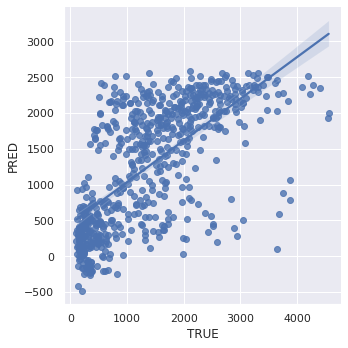

In [ ]:
# 0. Import
from sklearn.linear_model import LinearRegression

# 1. 인스턴스 생성
clf = LinearRegression()

# 2. fit
clf.fit(X_train, y_train)

# 3. predict
y_pred = clf.predict(X_valid)

# 4. 결과 확인
plot_result(y_valid, y_pred)

### XGBoost

[06:05:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1542.97
Will train until validation_0-rmse hasn't improved in 500 rounds.
[500]	validation_0-rmse:553.173
Stopping. Best iteration:
[208]	validation_0-rmse:546.92

R2 Score: 0.69049


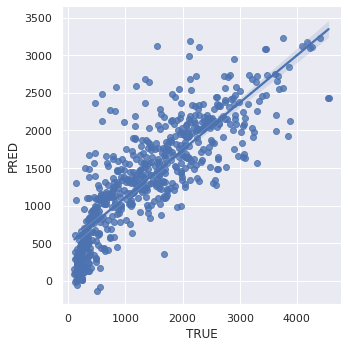

In [ ]:
# XGBoost 
xgbr = XGBRegressor(n_estimators = 1000)

# fit
xgbr.fit(X_train, y_train,
         eval_set=[(X_valid, y_valid)], 
         early_stopping_rounds = 500, 
         verbose=500)

# predict
y_pred = xgbr.predict(X_valid)

# check result
plot_result(y_valid, y_pred)

### LGBM

Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 331717
Early stopping, best iteration is:
[123]	valid_0's l2: 316684
R2 Score: 0.67232


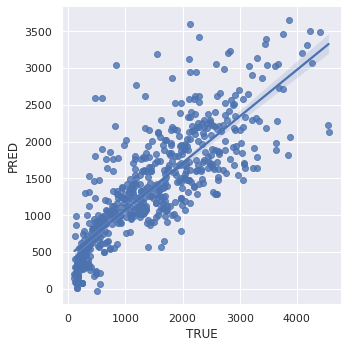

In [ ]:
from lightgbm import LGBMRegressor

# LGBM model
lgbr = LGBMRegressor(n_estimators = 1000)

# fit model
lgbr.fit(X_train, y_train,
         eval_set=[(X_valid, y_valid)], 
         early_stopping_rounds = 500, 
         verbose=500)
# predict
y_pred = lgbr.predict(X_valid)
# result
plot_result(y_valid, y_pred)

### Hyperparameter Tuning

XGBoost Hyperparameter Tuning

In [ ]:
def objective(trial, data = X_train, target = y):
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=.05, shuffle=False)

    param = {
        'n_estimators': 20000,
        'metric': 'mean_squared_error', 
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
    }

    model = XGBRegressor(**param)
    
    model.fit(train_x, train_y, 
              eval_set=[(test_x, test_y)], 
              early_stopping_rounds = 500, 
              verbose = False)
    
    preds = model.predict(test_x)

    eval_mse = mean_squared_error(test_y, preds)
    eval_r2 = r2_score(test_y, preds)
    print('MSE: {}'.format(eval_mse))
    print('R2 Score: {}'.format(eval_r2))
    
    return eval_r2

LGBM Hyperparameter Tuning

In [ ]:
def objective(trial,data = X_train,target = y):
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=.05, shuffle=False)
    
    param = {
        # 'tree_method': 'gpu_hist'
        'metric': 'mean_squared_error', 
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006, 0.008, 0.01, 0.014, 0.017, 0.01, 0.02, 0.05, 0.08]),
        'max_depth': trial.suggest_categorical('max_depth', [4, 5, 8, 10, 15, 20, 100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
    }

    model = LGBMRegressor(**param)  
    model.fit(train_x,train_y,
              eval_set=[(test_x,test_y)],
              early_stopping_rounds=500,
              verbose=500)
    
    preds = model.predict(test_x)
    eval_mse = mean_squared_error(test_y, preds)
    eval_r2 = r2_score(test_y, preds)
    print('MSE: {}'.format(eval_mse))
    print('R2 Score: {}'.format(eval_r2))
    
    return eval_r2

In [ ]:
# Optuna 프레임워크 사용해 하이퍼파라미터 튜닝
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-10-02 07:00:04,914] A new study created in memory with name: no-name-190a10d7-bbd7-4b5b-8fb9-64a59cf8b5cd


Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 164997
[1000]	valid_0's l2: 163322
[1500]	valid_0's l2: 162795
Early stopping, best iteration is:
[1273]	valid_0's l2: 162655


[I 2021-10-02 07:00:11,227] Trial 0 finished with value: 0.8316970106588896 and parameters: {'reg_alpha': 8.757285952256591, 'reg_lambda': 0.001112771092943179, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 15, 'num_leaves': 623, 'min_child_samples': 30}. Best is trial 0 with value: 0.8316970106588896.


MSE: 162655.49861524426
R2 Score: 0.8316970106588896
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 248887
[1000]	valid_0's l2: 231342
[1500]	valid_0's l2: 220154
[2000]	valid_0's l2: 216055
[2500]	valid_0's l2: 215060
[3000]	valid_0's l2: 212970
[3500]	valid_0's l2: 211298
[4000]	valid_0's l2: 209797
[4500]	valid_0's l2: 208471
[5000]	valid_0's l2: 208034
[5500]	valid_0's l2: 207596
[6000]	valid_0's l2: 207823
Early stopping, best iteration is:
[5790]	valid_0's l2: 207099


[I 2021-10-02 07:00:18,656] Trial 1 finished with value: 0.7857108756200969 and parameters: {'reg_alpha': 2.1089766516045483, 'reg_lambda': 0.033878920837059776, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 813, 'min_child_samples': 215}. Best is trial 0 with value: 0.8316970106588896.


MSE: 207098.54596339798
R2 Score: 0.7857108756200969
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 262220
[1000]	valid_0's l2: 262953
Early stopping, best iteration is:
[541]	valid_0's l2: 261030


[I 2021-10-02 07:00:21,821] Trial 2 finished with value: 0.7299070528248113 and parameters: {'reg_alpha': 0.006388205408667342, 'reg_lambda': 0.011347640292920937, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.08, 'max_depth': 100, 'num_leaves': 721, 'min_child_samples': 136}. Best is trial 0 with value: 0.8316970106588896.


MSE: 261029.84366012146
R2 Score: 0.7299070528248113
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 321256
[1000]	valid_0's l2: 210730
[1500]	valid_0's l2: 187561
[2000]	valid_0's l2: 178339
[2500]	valid_0's l2: 173979
[3000]	valid_0's l2: 171563
[3500]	valid_0's l2: 169098
[4000]	valid_0's l2: 167629
[4500]	valid_0's l2: 167300
[5000]	valid_0's l2: 166864
[5500]	valid_0's l2: 165925
[6000]	valid_0's l2: 165853
[6500]	valid_0's l2: 165877
Early stopping, best iteration is:
[6259]	valid_0's l2: 165729


[I 2021-10-02 07:00:33,798] Trial 3 finished with value: 0.8285170259163483 and parameters: {'reg_alpha': 3.470762109730585, 'reg_lambda': 0.2366141339989169, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.006, 'max_depth': 100, 'num_leaves': 779, 'min_child_samples': 148}. Best is trial 0 with value: 0.8316970106588896.


MSE: 165728.77738415898
R2 Score: 0.8285170259163483
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 161977
[1000]	valid_0's l2: 161436
Early stopping, best iteration is:
[655]	valid_0's l2: 160176


[I 2021-10-02 07:00:35,733] Trial 4 finished with value: 0.8342621731744202 and parameters: {'reg_alpha': 0.37399569371925107, 'reg_lambda': 0.2600629529492643, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.08, 'max_depth': 20, 'num_leaves': 251, 'min_child_samples': 121}. Best is trial 4 with value: 0.8342621731744202.


MSE: 160176.4114069527
R2 Score: 0.8342621731744202
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 238672
[1000]	valid_0's l2: 222120
[1500]	valid_0's l2: 205313
[2000]	valid_0's l2: 199384
[2500]	valid_0's l2: 197863
[3000]	valid_0's l2: 196069
Early stopping, best iteration is:
[2861]	valid_0's l2: 195704


[I 2021-10-02 07:00:37,947] Trial 5 finished with value: 0.7975014359434563 and parameters: {'reg_alpha': 0.006769192255830644, 'reg_lambda': 0.0025602237523440416, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 5, 'num_leaves': 115, 'min_child_samples': 271}. Best is trial 4 with value: 0.8342621731744202.


MSE: 195703.62377064818
R2 Score: 0.7975014359434563
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 202268
[1000]	valid_0's l2: 195046
[1500]	valid_0's l2: 194832
[2000]	valid_0's l2: 193782
Early stopping, best iteration is:
[1827]	valid_0's l2: 192132


[I 2021-10-02 07:00:41,131] Trial 6 finished with value: 0.8011965729192984 and parameters: {'reg_alpha': 0.01121163545703669, 'reg_lambda': 0.09351401808171064, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.08, 'max_depth': 10, 'num_leaves': 711, 'min_child_samples': 208}. Best is trial 4 with value: 0.8342621731744202.


MSE: 192132.4789584841
R2 Score: 0.8011965729192984
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 219364
[1000]	valid_0's l2: 191500
[1500]	valid_0's l2: 180570
[2000]	valid_0's l2: 178755
[2500]	valid_0's l2: 175824
[3000]	valid_0's l2: 174091
[3500]	valid_0's l2: 174434
Early stopping, best iteration is:
[3094]	valid_0's l2: 173785


[I 2021-10-02 07:00:45,361] Trial 7 finished with value: 0.8201808583585694 and parameters: {'reg_alpha': 0.02507773728201629, 'reg_lambda': 0.02273586985692909, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 15, 'num_leaves': 706, 'min_child_samples': 225}. Best is trial 4 with value: 0.8342621731744202.


MSE: 173785.22068299202
R2 Score: 0.8201808583585694
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 305162


[I 2021-10-02 07:00:46,242] Trial 8 finished with value: 0.6877305436988912 and parameters: {'reg_alpha': 0.09289965418147182, 'reg_lambda': 0.00254298702116159, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 5, 'num_leaves': 27, 'min_child_samples': 213}. Best is trial 4 with value: 0.8342621731744202.


Early stopping, best iteration is:
[473]	valid_0's l2: 301791
MSE: 301791.09899244853
R2 Score: 0.6877305436988912
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 207711
[1000]	valid_0's l2: 197607
[1500]	valid_0's l2: 194042
[2000]	valid_0's l2: 192452
[2500]	valid_0's l2: 193753
Early stopping, best iteration is:
[2407]	valid_0's l2: 191618


[I 2021-10-02 07:00:49,270] Trial 9 finished with value: 0.8017291359178041 and parameters: {'reg_alpha': 0.020932086513070536, 'reg_lambda': 2.885205436071692, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.08, 'max_depth': 5, 'num_leaves': 948, 'min_child_samples': 50}. Best is trial 4 with value: 0.8342621731744202.


MSE: 191617.7863769375
R2 Score: 0.8017291359178041
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 172280
[1000]	valid_0's l2: 169648
Early stopping, best iteration is:
[911]	valid_0's l2: 168963


[I 2021-10-02 07:00:52,244] Trial 10 finished with value: 0.8251703358224115 and parameters: {'reg_alpha': 0.4519886827934814, 'reg_lambda': 1.38035477611682, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.05, 'max_depth': 20, 'num_leaves': 342, 'min_child_samples': 92}. Best is trial 4 with value: 0.8342621731744202.


MSE: 168963.16762328125
R2 Score: 0.8251703358224115
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 228458
[1000]	valid_0's l2: 223355
[1500]	valid_0's l2: 222862
Early stopping, best iteration is:
[1101]	valid_0's l2: 222829


[I 2021-10-02 07:01:01,313] Trial 11 finished with value: 0.7694339968182006 and parameters: {'reg_alpha': 9.069514208990116, 'reg_lambda': 0.42774841263123314, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 15, 'num_leaves': 432, 'min_child_samples': 16}. Best is trial 4 with value: 0.8342621731744202.


MSE: 222829.24598118817
R2 Score: 0.7694339968182006
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 186661
[1000]	valid_0's l2: 175184
[1500]	valid_0's l2: 173350
[2000]	valid_0's l2: 172177
[2500]	valid_0's l2: 171008
[3000]	valid_0's l2: 171888
Early stopping, best iteration is:
[2597]	valid_0's l2: 170683


[I 2021-10-02 07:01:08,786] Trial 12 finished with value: 0.8233912664002321 and parameters: {'reg_alpha': 0.6281372948800762, 'reg_lambda': 0.0012735395283920603, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 280, 'min_child_samples': 87}. Best is trial 4 with value: 0.8342621731744202.


MSE: 170682.53948392745
R2 Score: 0.8233912664002321
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 324269
[1000]	valid_0's l2: 291985


[I 2021-10-02 07:01:09,815] Trial 13 finished with value: 0.7004903110461752 and parameters: {'reg_alpha': 0.1693159431136494, 'reg_lambda': 8.158124898377913, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 4, 'num_leaves': 584, 'min_child_samples': 15}. Best is trial 4 with value: 0.8342621731744202.


Early stopping, best iteration is:
[984]	valid_0's l2: 289459
MSE: 289459.492000724
R2 Score: 0.7004903110461752
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 198785
[1000]	valid_0's l2: 183884
[1500]	valid_0's l2: 178932
[2000]	valid_0's l2: 177825
[2500]	valid_0's l2: 176961
[3000]	valid_0's l2: 176286
[3500]	valid_0's l2: 175541
[4000]	valid_0's l2: 174662
[4500]	valid_0's l2: 174542
Early stopping, best iteration is:
[4481]	valid_0's l2: 174505


[I 2021-10-02 07:01:20,991] Trial 14 finished with value: 0.8194365581028744 and parameters: {'reg_alpha': 1.2981813816540824, 'reg_lambda': 0.11153012738790967, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 192, 'min_child_samples': 101}. Best is trial 4 with value: 0.8342621731744202.


MSE: 174504.54557248735
R2 Score: 0.8194365581028744
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 284125
[1000]	valid_0's l2: 243166
[1500]	valid_0's l2: 246584
Early stopping, best iteration is:
[1039]	valid_0's l2: 242178


[I 2021-10-02 07:01:24,578] Trial 15 finished with value: 0.7494130332332807 and parameters: {'reg_alpha': 0.001765051092894549, 'reg_lambda': 0.8271228940390954, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 15, 'num_leaves': 504, 'min_child_samples': 65}. Best is trial 4 with value: 0.8342621731744202.


MSE: 242178.39615024778
R2 Score: 0.7494130332332807
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 205172
[1000]	valid_0's l2: 179090
[1500]	valid_0's l2: 172757
[2000]	valid_0's l2: 170051
[2500]	valid_0's l2: 168349
[3000]	valid_0's l2: 166766
[3500]	valid_0's l2: 166225
[4000]	valid_0's l2: 164749
[4500]	valid_0's l2: 164145
[5000]	valid_0's l2: 163668
[5500]	valid_0's l2: 164049
Early stopping, best iteration is:
[5111]	valid_0's l2: 163547


[I 2021-10-02 07:01:31,522] Trial 16 finished with value: 0.8307749217172369 and parameters: {'reg_alpha': 6.118420931878081, 'reg_lambda': 0.008296349908725261, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 560, 'min_child_samples': 123}. Best is trial 4 with value: 0.8342621731744202.


MSE: 163546.64640269172
R2 Score: 0.8307749217172369
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 317296
[1000]	valid_0's l2: 277726
[1500]	valid_0's l2: 264002
[2000]	valid_0's l2: 256499
[2500]	valid_0's l2: 252704
[3000]	valid_0's l2: 251741
[3500]	valid_0's l2: 248917
[4000]	valid_0's l2: 245274
[4500]	valid_0's l2: 243842
[5000]	valid_0's l2: 243041
[5500]	valid_0's l2: 242481
[6000]	valid_0's l2: 241085
[6500]	valid_0's l2: 240100
[7000]	valid_0's l2: 238432
[7500]	valid_0's l2: 237852
[8000]	valid_0's l2: 236865
[8500]	valid_0's l2: 235977
[9000]	valid_0's l2: 235433
[9500]	valid_0's l2: 235073
[10000]	valid_0's l2: 234635
[10500]	valid_0's l2: 233376
[11000]	valid_0's l2: 233290
[11500]	valid_0's l2: 232318
[12000]	valid_0's l2: 232209
[12500]	valid_0's l2: 232426
[13000]	valid_0's l2: 232038
[13500]	valid_0's l2: 231240
[14000]	valid_0's l2: 231251
Early stopping, best iteration is:
[13618]	valid_0's l2: 230703


[I 2021-10-02 07:01:52,884] Trial 17 finished with value: 0.7612871295729408 and parameters: {'reg_alpha': 0.1269528321167632, 'reg_lambda': 0.06420480138805154, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 384, 'min_child_samples': 181}. Best is trial 4 with value: 0.8342621731744202.


MSE: 230702.74103387672
R2 Score: 0.7612871295729408
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 372223
[1000]	valid_0's l2: 348729
[1500]	valid_0's l2: 297254
[2000]	valid_0's l2: 276273
[2500]	valid_0's l2: 265689
[3000]	valid_0's l2: 257452
[3500]	valid_0's l2: 251901
[4000]	valid_0's l2: 248272
[4500]	valid_0's l2: 243505
[5000]	valid_0's l2: 237820
[5500]	valid_0's l2: 235120
[6000]	valid_0's l2: 233571
[6500]	valid_0's l2: 231341
[7000]	valid_0's l2: 227854
[7500]	valid_0's l2: 227096
[8000]	valid_0's l2: 226342
[8500]	valid_0's l2: 224433
[9000]	valid_0's l2: 222611
[9500]	valid_0's l2: 222157
[10000]	valid_0's l2: 219830
[10500]	valid_0's l2: 218270
Early stopping, best iteration is:
[10434]	valid_0's l2: 217728


[I 2021-10-02 07:02:02,401] Trial 18 finished with value: 0.7747128234012185 and parameters: {'reg_alpha': 0.4746827246043041, 'reg_lambda': 0.18272198836935602, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 4, 'num_leaves': 234, 'min_child_samples': 46}. Best is trial 4 with value: 0.8342621731744202.


MSE: 217727.55305626956
R2 Score: 0.7747128234012185
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 321529
[1000]	valid_0's l2: 320118
Early stopping, best iteration is:
[692]	valid_0's l2: 317679


[I 2021-10-02 07:02:32,673] Trial 19 finished with value: 0.6712914948655375 and parameters: {'reg_alpha': 0.050531500081260707, 'reg_lambda': 0.009595096156210663, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 940, 'min_child_samples': 2}. Best is trial 4 with value: 0.8342621731744202.


MSE: 317678.5273454301
R2 Score: 0.6712914948655375
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 223662
[1000]	valid_0's l2: 200284
[1500]	valid_0's l2: 191479
[2000]	valid_0's l2: 189710
[2500]	valid_0's l2: 188338
[3000]	valid_0's l2: 188293
[3500]	valid_0's l2: 187319
[4000]	valid_0's l2: 186441
[4500]	valid_0's l2: 186306
[5000]	valid_0's l2: 186027
[5500]	valid_0's l2: 185486
[6000]	valid_0's l2: 185814
Early stopping, best iteration is:
[5538]	valid_0's l2: 185416


[I 2021-10-02 07:02:42,769] Trial 20 finished with value: 0.8081466189624348 and parameters: {'reg_alpha': 0.9529554015326986, 'reg_lambda': 0.5213519867951417, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 15, 'num_leaves': 605, 'min_child_samples': 179}. Best is trial 4 with value: 0.8342621731744202.


MSE: 185415.64517572772
R2 Score: 0.8081466189624348
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 206025
[1000]	valid_0's l2: 180574
[1500]	valid_0's l2: 173260
[2000]	valid_0's l2: 169054
[2500]	valid_0's l2: 167791
[3000]	valid_0's l2: 166990
[3500]	valid_0's l2: 166561
[4000]	valid_0's l2: 165177
[4500]	valid_0's l2: 163780
[5000]	valid_0's l2: 163268
[5500]	valid_0's l2: 163124
Early stopping, best iteration is:
[5240]	valid_0's l2: 162982


[I 2021-10-02 07:02:49,697] Trial 21 finished with value: 0.8313594216872768 and parameters: {'reg_alpha': 8.72499691566498, 'reg_lambda': 0.00597033208845326, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 530, 'min_child_samples': 119}. Best is trial 4 with value: 0.8342621731744202.


MSE: 162981.7596205874
R2 Score: 0.8313594216872768
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 205783
[1000]	valid_0's l2: 179650
[1500]	valid_0's l2: 173265
[2000]	valid_0's l2: 169282
[2500]	valid_0's l2: 167093
[3000]	valid_0's l2: 166119
[3500]	valid_0's l2: 164777
[4000]	valid_0's l2: 163352
[4500]	valid_0's l2: 162526
[5000]	valid_0's l2: 161890
[5500]	valid_0's l2: 161794
[6000]	valid_0's l2: 161831
Early stopping, best iteration is:
[5770]	valid_0's l2: 161528


[I 2021-10-02 07:02:57,161] Trial 22 finished with value: 0.8328639910158174 and parameters: {'reg_alpha': 3.6167388117418486, 'reg_lambda': 0.0013735149722596807, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 497, 'min_child_samples': 122}. Best is trial 4 with value: 0.8342621731744202.


MSE: 161527.67686606795
R2 Score: 0.8328639910158174
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 186363
[1000]	valid_0's l2: 169183
[1500]	valid_0's l2: 164162
[2000]	valid_0's l2: 162100
[2500]	valid_0's l2: 161501
Early stopping, best iteration is:
[2261]	valid_0's l2: 161155


[I 2021-10-02 07:03:00,284] Trial 23 finished with value: 0.8332498548273988 and parameters: {'reg_alpha': 3.8063662886079115, 'reg_lambda': 0.0027966032781386843, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 8, 'num_leaves': 454, 'min_child_samples': 168}. Best is trial 4 with value: 0.8342621731744202.


MSE: 161154.76090708197
R2 Score: 0.8332498548273988
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 232433
[1000]	valid_0's l2: 186199
[1500]	valid_0's l2: 179880
[2000]	valid_0's l2: 173365
[2500]	valid_0's l2: 170345
[3000]	valid_0's l2: 168588
[3500]	valid_0's l2: 166350
[4000]	valid_0's l2: 166098
[4500]	valid_0's l2: 165546
[5000]	valid_0's l2: 164720
[5500]	valid_0's l2: 164439
[6000]	valid_0's l2: 164019
[6500]	valid_0's l2: 164087
Early stopping, best iteration is:
[6081]	valid_0's l2: 163894


[I 2021-10-02 07:03:07,715] Trial 24 finished with value: 0.8304153925966313 and parameters: {'reg_alpha': 3.465452517855311, 'reg_lambda': 0.004530654730157266, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 434, 'min_child_samples': 171}. Best is trial 4 with value: 0.8342621731744202.


MSE: 163894.11134438848
R2 Score: 0.8304153925966313
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 232231
[1000]	valid_0's l2: 184898
[1500]	valid_0's l2: 178019
[2000]	valid_0's l2: 172265
[2500]	valid_0's l2: 169447
[3000]	valid_0's l2: 168085
[3500]	valid_0's l2: 167022
[4000]	valid_0's l2: 165638
[4500]	valid_0's l2: 165606
[5000]	valid_0's l2: 164639
[5500]	valid_0's l2: 164269
Early stopping, best iteration is:
[5277]	valid_0's l2: 163973


[I 2021-10-02 07:03:14,094] Trial 25 finished with value: 0.8303335129000073 and parameters: {'reg_alpha': 0.26697996408520736, 'reg_lambda': 0.019298720220864592, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 303, 'min_child_samples': 161}. Best is trial 4 with value: 0.8342621731744202.


MSE: 163973.24352696573
R2 Score: 0.8303335129000073
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 249044
[1000]	valid_0's l2: 222206
[1500]	valid_0's l2: 206692
[2000]	valid_0's l2: 200933
[2500]	valid_0's l2: 197730
[3000]	valid_0's l2: 195886
[3500]	valid_0's l2: 194777
[4000]	valid_0's l2: 193682
[4500]	valid_0's l2: 193268
Early stopping, best iteration is:
[4459]	valid_0's l2: 192977


[I 2021-10-02 07:03:19,364] Trial 26 finished with value: 0.8003229510953825 and parameters: {'reg_alpha': 1.7972709053791744, 'reg_lambda': 0.0024003202458539024, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 147, 'min_child_samples': 253}. Best is trial 4 with value: 0.8342621731744202.


MSE: 192976.78596649683
R2 Score: 0.8003229510953825
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 223505
[1000]	valid_0's l2: 179489
[1500]	valid_0's l2: 172387
[2000]	valid_0's l2: 167366
[2500]	valid_0's l2: 164389
[3000]	valid_0's l2: 163522
[3500]	valid_0's l2: 162351
[4000]	valid_0's l2: 161638
[4500]	valid_0's l2: 160905
[5000]	valid_0's l2: 160575
[5500]	valid_0's l2: 160236
[6000]	valid_0's l2: 159541
[6500]	valid_0's l2: 159258
Early stopping, best iteration is:
[6311]	valid_0's l2: 159099


[I 2021-10-02 07:03:27,328] Trial 27 finished with value: 0.8353766389620197 and parameters: {'reg_alpha': 3.486777642277594, 'reg_lambda': 0.061805801813863824, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 436, 'min_child_samples': 118}. Best is trial 27 with value: 0.8353766389620197.


MSE: 159099.34207454638
R2 Score: 0.8353766389620197
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 280319
[1000]	valid_0's l2: 241834
[1500]	valid_0's l2: 246448
Early stopping, best iteration is:
[1037]	valid_0's l2: 240898


[I 2021-10-02 07:03:30,829] Trial 28 finished with value: 0.7507383150347405 and parameters: {'reg_alpha': 0.27796642061408605, 'reg_lambda': 0.03438019878271566, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 398, 'min_child_samples': 70}. Best is trial 27 with value: 0.8353766389620197.


MSE: 240897.58484044232
R2 Score: 0.7507383150347405
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 237836
[1000]	valid_0's l2: 191727
[1500]	valid_0's l2: 183566
[2000]	valid_0's l2: 177002
[2500]	valid_0's l2: 172729
[3000]	valid_0's l2: 171157
[3500]	valid_0's l2: 170202
[4000]	valid_0's l2: 168843
[4500]	valid_0's l2: 168333
[5000]	valid_0's l2: 167937
[5500]	valid_0's l2: 167810
[6000]	valid_0's l2: 167189
[6500]	valid_0's l2: 167494
Early stopping, best iteration is:
[6081]	valid_0's l2: 167075


[I 2021-10-02 07:03:37,749] Trial 29 finished with value: 0.8271238833768522 and parameters: {'reg_alpha': 0.8152741280705997, 'reg_lambda': 0.2847916227304117, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 249, 'min_child_samples': 196}. Best is trial 27 with value: 0.8353766389620197.


MSE: 167075.17233109946
R2 Score: 0.8271238833768522
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 230261
[1000]	valid_0's l2: 183837
[1500]	valid_0's l2: 175918
[2000]	valid_0's l2: 170329
[2500]	valid_0's l2: 166778
[3000]	valid_0's l2: 165574
Early stopping, best iteration is:
[2964]	valid_0's l2: 165461


[I 2021-10-02 07:03:43,510] Trial 30 finished with value: 0.8287946050567262 and parameters: {'reg_alpha': 1.9212032983605185, 'reg_lambda': 1.5404705734805257, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 342, 'min_child_samples': 147}. Best is trial 27 with value: 0.8353766389620197.


MSE: 165460.51255024184
R2 Score: 0.8287946050567262
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 224175
[1000]	valid_0's l2: 179064
[1500]	valid_0's l2: 172752
[2000]	valid_0's l2: 167741
[2500]	valid_0's l2: 164176
[3000]	valid_0's l2: 162833
[3500]	valid_0's l2: 161491
[4000]	valid_0's l2: 160163
[4500]	valid_0's l2: 160215
[5000]	valid_0's l2: 159839
[5500]	valid_0's l2: 159177
[6000]	valid_0's l2: 158244
[6500]	valid_0's l2: 157986
Early stopping, best iteration is:
[6497]	valid_0's l2: 157943


[I 2021-10-02 07:03:51,508] Trial 31 finished with value: 0.8365727515116197 and parameters: {'reg_alpha': 3.75942457222522, 'reg_lambda': 0.0011180289689157413, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 457, 'min_child_samples': 124}. Best is trial 31 with value: 0.8365727515116197.


MSE: 157943.3656779488
R2 Score: 0.8365727515116197
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 220163
[1000]	valid_0's l2: 176233
[1500]	valid_0's l2: 169147
[2000]	valid_0's l2: 164090
[2500]	valid_0's l2: 162954
[3000]	valid_0's l2: 161407
[3500]	valid_0's l2: 160163
[4000]	valid_0's l2: 159443
[4500]	valid_0's l2: 159359
[5000]	valid_0's l2: 158839
[5500]	valid_0's l2: 158540
[6000]	valid_0's l2: 157917
[6500]	valid_0's l2: 157618
[7000]	valid_0's l2: 157555
[7500]	valid_0's l2: 157836
Early stopping, best iteration is:
[7066]	valid_0's l2: 157430


[I 2021-10-02 07:04:00,414] Trial 32 finished with value: 0.8371035155707781 and parameters: {'reg_alpha': 4.015202970279836, 'reg_lambda': 0.0010533031782607118, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 477, 'min_child_samples': 107}. Best is trial 32 with value: 0.8371035155707781.


MSE: 157430.4116714428
R2 Score: 0.8371035155707781
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 221671
[1000]	valid_0's l2: 177848
[1500]	valid_0's l2: 170063
[2000]	valid_0's l2: 164915
[2500]	valid_0's l2: 162789
[3000]	valid_0's l2: 161521
[3500]	valid_0's l2: 160152
[4000]	valid_0's l2: 159455
[4500]	valid_0's l2: 159131
[5000]	valid_0's l2: 158243
[5500]	valid_0's l2: 157949
[6000]	valid_0's l2: 157435
[6500]	valid_0's l2: 157349
Early stopping, best iteration is:
[6378]	valid_0's l2: 157237


[I 2021-10-02 07:04:08,666] Trial 33 finished with value: 0.8373037424198828 and parameters: {'reg_alpha': 1.3844254977135082, 'reg_lambda': 0.04613957540099872, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 658, 'min_child_samples': 108}. Best is trial 33 with value: 0.8373037424198828.


MSE: 157236.90353409603
R2 Score: 0.8373037424198828
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 219148
[1000]	valid_0's l2: 176017
[1500]	valid_0's l2: 168712
[2000]	valid_0's l2: 163973
[2500]	valid_0's l2: 161116
[3000]	valid_0's l2: 159207
[3500]	valid_0's l2: 157789
[4000]	valid_0's l2: 157413
[4500]	valid_0's l2: 156958
[5000]	valid_0's l2: 155978
[5500]	valid_0's l2: 155789
[6000]	valid_0's l2: 155233
[6500]	valid_0's l2: 155137
[7000]	valid_0's l2: 155148
Early stopping, best iteration is:
[6769]	valid_0's l2: 155078


[I 2021-10-02 07:04:17,429] Trial 34 finished with value: 0.8395379694313669 and parameters: {'reg_alpha': 5.61010845257047, 'reg_lambda': 0.0010773886826606102, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 642, 'min_child_samples': 100}. Best is trial 34 with value: 0.8395379694313669.


MSE: 155077.64712400315
R2 Score: 0.8395379694313669
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 333837
[1000]	valid_0's l2: 303800
[1500]	valid_0's l2: 293936
[2000]	valid_0's l2: 292252
[2500]	valid_0's l2: 287418
[3000]	valid_0's l2: 284791
[3500]	valid_0's l2: 281405
[4000]	valid_0's l2: 280664
[4500]	valid_0's l2: 277381
[5000]	valid_0's l2: 273783
[5500]	valid_0's l2: 273030
[6000]	valid_0's l2: 271173
[6500]	valid_0's l2: 269952
Early stopping, best iteration is:
[6355]	valid_0's l2: 269684


[I 2021-10-02 07:04:28,574] Trial 35 finished with value: 0.7209525803366383 and parameters: {'reg_alpha': 6.2159601689985235, 'reg_lambda': 0.0011165341439162428, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 655, 'min_child_samples': 100}. Best is trial 34 with value: 0.8395379694313669.


MSE: 269683.8443591126
R2 Score: 0.7209525803366383
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 275956
[1000]	valid_0's l2: 240869
[1500]	valid_0's l2: 243224
Early stopping, best iteration is:
[1044]	valid_0's l2: 240005


[I 2021-10-02 07:04:31,072] Trial 36 finished with value: 0.7516622834721285 and parameters: {'reg_alpha': 1.6105528414844366, 'reg_lambda': 0.004184016549506148, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 806, 'min_child_samples': 75}. Best is trial 34 with value: 0.8395379694313669.


MSE: 240004.62062467614
R2 Score: 0.7516622834721285
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 226002
[1000]	valid_0's l2: 182492
[1500]	valid_0's l2: 176359
[2000]	valid_0's l2: 170242
[2500]	valid_0's l2: 167607
[3000]	valid_0's l2: 166177
[3500]	valid_0's l2: 164331
[4000]	valid_0's l2: 163285
[4500]	valid_0's l2: 162163
[5000]	valid_0's l2: 162279
Early stopping, best iteration is:
[4538]	valid_0's l2: 162045


[I 2021-10-02 07:04:37,235] Trial 37 finished with value: 0.83232864382897 and parameters: {'reg_alpha': 6.298153865161763, 'reg_lambda': 0.0010194011167783755, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 853, 'min_child_samples': 138}. Best is trial 34 with value: 0.8395379694313669.


MSE: 162045.06021112818
R2 Score: 0.83232864382897
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 271315
[1000]	valid_0's l2: 203870
[1500]	valid_0's l2: 188603
[2000]	valid_0's l2: 181937
[2500]	valid_0's l2: 178792
[3000]	valid_0's l2: 176739
[3500]	valid_0's l2: 175257
[4000]	valid_0's l2: 174572
[4500]	valid_0's l2: 173980
[5000]	valid_0's l2: 173313
[5500]	valid_0's l2: 172543
[6000]	valid_0's l2: 172258
[6500]	valid_0's l2: 172346
Early stopping, best iteration is:
[6202]	valid_0's l2: 172172


[I 2021-10-02 07:04:50,108] Trial 38 finished with value: 0.8218497204249198 and parameters: {'reg_alpha': 2.697915262899276, 'reg_lambda': 0.0017650292442648945, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 100, 'num_leaves': 662, 'min_child_samples': 106}. Best is trial 34 with value: 0.8395379694313669.


MSE: 172172.35811539894
R2 Score: 0.8218497204249198
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 218328
Early stopping, best iteration is:
[465]	valid_0's l2: 216627


[I 2021-10-02 07:04:52,865] Trial 39 finished with value: 0.7758513696587793 and parameters: {'reg_alpha': 5.180134133830304, 'reg_lambda': 0.016471412951356304, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 763, 'min_child_samples': 54}. Best is trial 34 with value: 0.8395379694313669.


MSE: 216627.2112860783
R2 Score: 0.7758513696587793
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 225554
[1000]	valid_0's l2: 181768
[1500]	valid_0's l2: 174930
[2000]	valid_0's l2: 169143
[2500]	valid_0's l2: 166074
[3000]	valid_0's l2: 165168
[3500]	valid_0's l2: 163971
[4000]	valid_0's l2: 162966
[4500]	valid_0's l2: 162743
[5000]	valid_0's l2: 162224
[5500]	valid_0's l2: 161825
[6000]	valid_0's l2: 160606
[6500]	valid_0's l2: 160196
[7000]	valid_0's l2: 160323
[7500]	valid_0's l2: 159702
[8000]	valid_0's l2: 159552
[8500]	valid_0's l2: 159524
Early stopping, best iteration is:
[8115]	valid_0's l2: 159373


[I 2021-10-02 07:05:02,605] Trial 40 finished with value: 0.8350935159521222 and parameters: {'reg_alpha': 1.058563891478802, 'reg_lambda': 0.004819311243789193, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 643, 'min_child_samples': 138}. Best is trial 34 with value: 0.8395379694313669.


MSE: 159372.9647506772
R2 Score: 0.8350935159521222
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 220560
[1000]	valid_0's l2: 177579
[1500]	valid_0's l2: 170574
[2000]	valid_0's l2: 165052
[2500]	valid_0's l2: 163094
[3000]	valid_0's l2: 161190
[3500]	valid_0's l2: 160521
[4000]	valid_0's l2: 158869
[4500]	valid_0's l2: 159156
Early stopping, best iteration is:
[4226]	valid_0's l2: 158767


[I 2021-10-02 07:05:08,389] Trial 41 finished with value: 0.835720621463115 and parameters: {'reg_alpha': 2.4036144361002485, 'reg_lambda': 0.08533868089118128, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 546, 'min_child_samples': 113}. Best is trial 34 with value: 0.8395379694313669.


MSE: 158766.9020777904
R2 Score: 0.835720621463115
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 216174
[1000]	valid_0's l2: 174651
[1500]	valid_0's l2: 167001
[2000]	valid_0's l2: 162754
[2500]	valid_0's l2: 160737
[3000]	valid_0's l2: 158971
[3500]	valid_0's l2: 157263
[4000]	valid_0's l2: 156397
[4500]	valid_0's l2: 155976
[5000]	valid_0's l2: 155422
[5500]	valid_0's l2: 155053
[6000]	valid_0's l2: 154373
[6500]	valid_0's l2: 154155
[7000]	valid_0's l2: 153538
[7500]	valid_0's l2: 153449
[8000]	valid_0's l2: 153458
Early stopping, best iteration is:
[7522]	valid_0's l2: 153437


[I 2021-10-02 07:05:18,007] Trial 42 finished with value: 0.8412350786342494 and parameters: {'reg_alpha': 2.537510156929407, 'reg_lambda': 0.0017767493177498232, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 555, 'min_child_samples': 84}. Best is trial 42 with value: 0.8412350786342494.


MSE: 153437.48526662873
R2 Score: 0.8412350786342494
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 216665
[1000]	valid_0's l2: 174864
[1500]	valid_0's l2: 167110
[2000]	valid_0's l2: 162834
[2500]	valid_0's l2: 160385
[3000]	valid_0's l2: 158213
[3500]	valid_0's l2: 157036
[4000]	valid_0's l2: 156782
[4500]	valid_0's l2: 156020
[5000]	valid_0's l2: 155245
[5500]	valid_0's l2: 155012
[6000]	valid_0's l2: 154586
[6500]	valid_0's l2: 154329
[7000]	valid_0's l2: 153904
[7500]	valid_0's l2: 153639
[8000]	valid_0's l2: 153522
Early stopping, best iteration is:
[7852]	valid_0's l2: 153454


[I 2021-10-02 07:05:28,297] Trial 43 finished with value: 0.8412183187511322 and parameters: {'reg_alpha': 2.253908662543209, 'reg_lambda': 0.0017748074966223181, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 699, 'min_child_samples': 81}. Best is trial 42 with value: 0.8412350786342494.


MSE: 153453.6827635113
R2 Score: 0.8412183187511322
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 298607
[1000]	valid_0's l2: 270587
[1500]	valid_0's l2: 251705
[2000]	valid_0's l2: 239884
[2500]	valid_0's l2: 231556
[3000]	valid_0's l2: 228483
[3500]	valid_0's l2: 225570
[4000]	valid_0's l2: 223618
[4500]	valid_0's l2: 220792
[5000]	valid_0's l2: 220243
[5500]	valid_0's l2: 218102
[6000]	valid_0's l2: 217318
[6500]	valid_0's l2: 214583
[7000]	valid_0's l2: 213828
[7500]	valid_0's l2: 212477
[8000]	valid_0's l2: 211988
Early stopping, best iteration is:
[7741]	valid_0's l2: 211278


[I 2021-10-02 07:05:36,491] Trial 44 finished with value: 0.781386697276311 and parameters: {'reg_alpha': 1.421784788103028, 'reg_lambda': 0.0020900580998290154, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 5, 'num_leaves': 730, 'min_child_samples': 81}. Best is trial 42 with value: 0.8412350786342494.


MSE: 211277.6243467546
R2 Score: 0.781386697276311
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 410244
[1000]	valid_0's l2: 347703
[1500]	valid_0's l2: 284953
[2000]	valid_0's l2: 260018
[2500]	valid_0's l2: 255021
[3000]	valid_0's l2: 247760
[3500]	valid_0's l2: 243909
[4000]	valid_0's l2: 242143
[4500]	valid_0's l2: 239360
[5000]	valid_0's l2: 236535
[5500]	valid_0's l2: 235138
[6000]	valid_0's l2: 233492
[6500]	valid_0's l2: 233291
[7000]	valid_0's l2: 231192
[7500]	valid_0's l2: 230476
[8000]	valid_0's l2: 228899
[8500]	valid_0's l2: 229435
Early stopping, best iteration is:
[8113]	valid_0's l2: 228239


[I 2021-10-02 07:05:44,657] Trial 45 finished with value: 0.7638364734094689 and parameters: {'reg_alpha': 8.56126370799143, 'reg_lambda': 0.003199507826128299, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 4, 'num_leaves': 865, 'min_child_samples': 60}. Best is trial 42 with value: 0.8412350786342494.


MSE: 228238.94170092637
R2 Score: 0.7638364734094689
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 217251
[1000]	valid_0's l2: 176130
[1500]	valid_0's l2: 168236
[2000]	valid_0's l2: 163555
[2500]	valid_0's l2: 160862
[3000]	valid_0's l2: 159336
[3500]	valid_0's l2: 158048
[4000]	valid_0's l2: 157317
[4500]	valid_0's l2: 157356
Early stopping, best iteration is:
[4255]	valid_0's l2: 156945


[I 2021-10-02 07:05:50,937] Trial 46 finished with value: 0.8376056735995043 and parameters: {'reg_alpha': 0.6211059716600961, 'reg_lambda': 0.03389679892364016, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 696, 'min_child_samples': 84}. Best is trial 42 with value: 0.8412350786342494.


MSE: 156945.10380575433
R2 Score: 0.8376056735995043
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 303115
[1000]	valid_0's l2: 240574
[1500]	valid_0's l2: 234796
Early stopping, best iteration is:
[1380]	valid_0's l2: 233414


[I 2021-10-02 07:05:54,189] Trial 47 finished with value: 0.7584817019537426 and parameters: {'reg_alpha': 0.47735732847195284, 'reg_lambda': 0.03419587329641571, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 689, 'min_child_samples': 38}. Best is trial 42 with value: 0.8412350786342494.


MSE: 233414.03113048227
R2 Score: 0.7584817019537426
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 277059


[I 2021-10-02 07:05:55,189] Trial 48 finished with value: 0.7215810785610361 and parameters: {'reg_alpha': 0.9214320669698142, 'reg_lambda': 0.00675432277656986, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'num_leaves': 757, 'min_child_samples': 90}. Best is trial 42 with value: 0.8412350786342494.


Early stopping, best iteration is:
[413]	valid_0's l2: 269076
MSE: 269076.4357060136
R2 Score: 0.7215810785610361
Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l2: 218398
[1000]	valid_0's l2: 176231
[1500]	valid_0's l2: 167455
[2000]	valid_0's l2: 163463
[2500]	valid_0's l2: 161292
[3000]	valid_0's l2: 159299
[3500]	valid_0's l2: 158396
[4000]	valid_0's l2: 157493
[4500]	valid_0's l2: 156492
[5000]	valid_0's l2: 156230
[5500]	valid_0's l2: 155999
[6000]	valid_0's l2: 155447
[6500]	valid_0's l2: 154958
Early stopping, best iteration is:
[6483]	valid_0's l2: 154908


[I 2021-10-02 07:06:05,851] Trial 49 finished with value: 0.8397134391959094 and parameters: {'reg_alpha': 0.5854543360527265, 'reg_lambda': 0.04745351489809719, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 695, 'min_child_samples': 82}. Best is trial 42 with value: 0.8412350786342494.


MSE: 154908.0653349019
R2 Score: 0.8397134391959094
Number of finished trials: 50
Best trial: {'reg_alpha': 2.537510156929407, 'reg_lambda': 0.0017767493177498232, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 555, 'min_child_samples': 84}


In [ ]:
params = study.best_params
params

{'colsample_bytree': 0.4,
 'learning_rate': 0.01,
 'max_depth': 8,
 'min_child_samples': 84,
 'num_leaves': 555,
 'reg_alpha': 2.537510156929407,
 'reg_lambda': 0.0017767493177498232,
 'subsample': 0.6}

R2 Score: 0.81940


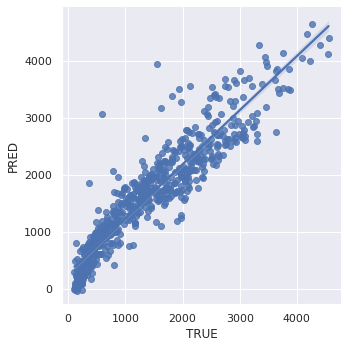

In [ ]:
# LightGBM > 파라미터 튜닝 O

params = {'colsample_bytree': 0.4,
          'learning_rate': 0.08,
          'max_depth': 5,
          'min_child_samples': 114,
          'num_leaves': 204,
          'reg_alpha': 0.0010251805749509925,
          'reg_lambda': 0.2671750951630589,
          'subsample': 1.0}

params['n_estimators'] = 7522
params['metric'] = 'mse'

model = LGBMRegressor(**params)  
model.fit(X_train, y_train, 
         verbose=500, 
         eval_metric = 'mse')

# predict
y_pred = model.predict(X_valid)
# result
plot_result(y_valid, y_pred)

R2 Score: 0.71032


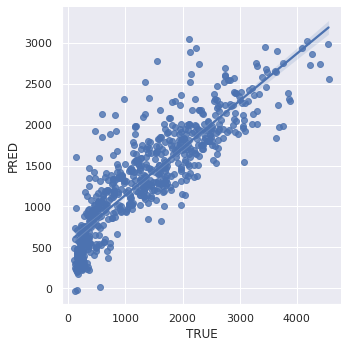

In [ ]:
# month, weekday, weekend 칼럼 추가
# LightGBM > 파라미터 튜닝 O 2번째

params = {'colsample_bytree': 0.4,
 'learning_rate': 0.01,
 'max_depth': 8,
 'min_child_samples': 84,
 'num_leaves': 555,
 'reg_alpha': 2.537510156929407,
 'reg_lambda': 0.0017767493177498232,
 'subsample': 0.6}

params['n_estimators'] = 96
params['metric'] = 'mse'

model = LGBMRegressor(**params)  
model.fit(X_train, y_train, 
         verbose=500, 
         eval_metric = 'mse')

# predict
y_pred = model.predict(X_valid)
# result
plot_result(y_valid, y_pred)

### K-Fold 

In [ ]:
from sklearn.model_selection import KFold

# split 개수
split = 10

# 10-fold cross-validation
kf = KFold(n_splits= split,random_state=42,shuffle=True)

# LGBMRegressor > 파라미터 튜닝 O
model = LGBMRegressor(**params)

eval_r2=[]  # 매 fold 마다 smape 값 저장할 list
n=0      # fold 번호

for trn_idx, test_idx in kf.split(X, y):
    X_tr, X_val = X[trn_idx], X[test_idx]
    y_tr, y_val = y[trn_idx], y[test_idx]

    model.fit(X_tr,y_tr,
              eval_set=[(X_val,y_val)],
              early_stopping_rounds=200,
              verbose=False)

    eval_r2.append(r2_score(y_val, model.predict(X_val)))
    print(n+1,eval_r2[n])
    n+=1

1 0.7758375031375427
2 0.7637895812390988
3 0.7737494619558032
4 0.7864842178631632
5 0.798133411455254
6 0.7838714846824014
7 0.7753112384146357
8 0.7833530721347088
9 0.7600914982985634
10 0.7966791954776102


In [ ]:
print('KFold Mean R2 Score: {}'.format(np.mean(eval_r2)))

KFold Mean R2 Score: 0.7797300664658782


### 신경망 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



R2 Score: 0.51858


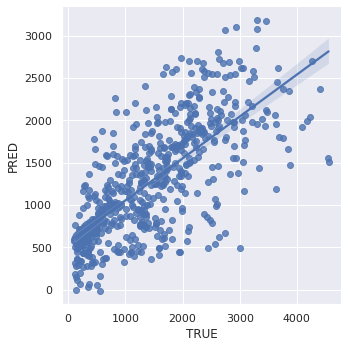

In [ ]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(
    hidden_layer_sizes=(128, 128),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='adaptive',
    learning_rate_init=1e-3,
    max_iter=200,
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)

plot_result(y_valid, y_pred)

## 앙상블

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



R2 Score: 0.57934


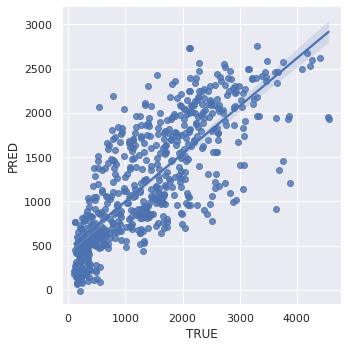

In [ ]:
from sklearn.ensemble import VotingRegressor

model_lr = LinearRegression()
model_lgbm = LGBMRegressor()
model_mlp = MLPRegressor()
estimators = [
    ('linear regression', model_lr),
    ('lgbm', model_lgbm),
    ('mlp', model_mlp)
]

voting_clf = VotingRegressor(estimators=estimators)
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_valid)

plot_result(y_valid, y_pred)

R2 Score: 0.66518


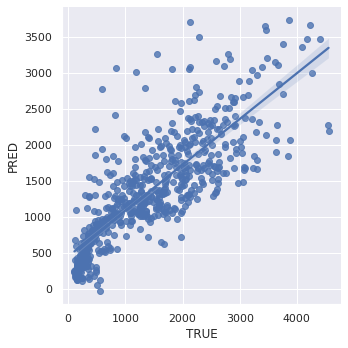

In [ ]:
from sklearn.ensemble import VotingRegressor


model_lgbm1 = LGBMRegressor(num_leaves=30)
model_lgbm2 = LGBMRegressor(num_leaves=60)
model_lgbm3 = LGBMRegressor(num_leaves=90)
estimators = [
    ('lgbm1', model_lgbm1),
    ('lgbm2', model_lgbm2),
    ('lgbm3', model_lgbm3),
]

voting_clf = VotingRegressor(estimators=estimators)
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_valid)

plot_result(y_valid, y_pred)

# 결과 제출

In [ ]:
# X_test = df_test_preprocess.drop(['Date'], axis=1)
# y_pred = model.predict(X_test)

In [ ]:
X_test

,Hour,Temperature,Rainfall,Windspeed,Humidity,Dewpoint,Snow,Visibility,Year,Month,Weekday,Weekend
0,-1.517594,-2.246986,-0.130954,0.166884,0.266523,-1.717271,-0.100834,0.923574,2021,1,4,0
1,-1.373110,-2.286023,-0.130954,-0.529027,0.317539,-1.734339,-0.100834,0.923574,2021,1,4,0
2,-1.228626,-2.305542,-0.130954,-0.963971,0.368555,-1.734339,-0.100834,0.923574,2021,1,4,0
3,-1.084142,-2.305542,-0.130954,-1.659882,0.419571,-1.717271,-0.100834,0.923574,2021,1,4,0
4,-0.939658,-2.344579,-0.130954,-0.268060,0.470587,-1.742873,-0.100834,0.923574,2021,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
714,1.083118,-0.675730,-0.130954,-1.137949,-0.549733,-0.718786,-0.100834,0.923574,2021,1,6,1
715,1.227602,-0.734286,-0.130954,-0.703005,-0.549733,-0.761457,-0.100834,0.923574,2021,1,6,1
716,1.372086,-0.763564,-0.130954,-0.963971,-0.447701,-0.744389,-0.100834,0.923574,2021,1,6,1
717,1.516570,-0.783082,-0.130954,-0.703005,-0.243637,-0.676116,-0.100834,0.923574,2021,1,6,1


In [2]:
df_test = pd.read_csv('./new_test1(1).csv')
X_test = df_test.drop(['Date'], axis=1)
y_pred = model.predict(X_test)

In [ ]:
today = datetime.now().strftime("%Y%m%d_%H%M%S")
submission = pd.DataFrame(y_pred, columns=['Rent Amount'])
submission['id'] = submission.index
submission.to_csv(f'./submission_{today}.csv', index=False)

In [ ]:
submission

,Rent Amount,id
0,464.557592,0
1,353.981371,1
2,186.738797,2
3,100.797528,3
4,84.673258,4
...,...,...
714,2534.381515,714
715,2267.240897,715
716,2318.432491,716
717,1943.156107,717
